## Code used for  Fig. 2 (Kim dataset)

This notebooks is a step-by-step reproduction of all analysis on the Kim dataset (Fig. 2).

In [1]:
#import everything here
import vireoSNP
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.io import mmread
from scipy.io import mmwrite
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from vireoSNP import BinomMixtureVB

from mquad.mquad_utils import findKnee, plot_confusionMatrix, confusionMatrix
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from vireoSNP.plot.base_plot import heat_matrix

print(vireoSNP.__version__)
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


## Input data

Here we read in the most important input data - AD and DP matrices, including variants detected by MQuad and mgatk respectively. There should be 146 variants for MQuad, and 273 variants for mgatk. We also import some additional data here for plotting purposes, such as variant names, BIC scores, mgatk metrics...etc

In [2]:
mquad_AD = mmread('data/mquad/passed_ad.mtx').tocsc()
mquad_DP = mmread('data/mquad/passed_dp.mtx').tocsc()

mquad_AD.shape, mquad_DP.shape

((146, 121), (146, 121))

In [3]:
mgatk_AD = mmread('data/mgatk/mgatk_AD.mtx').tocsc()
mgatk_DP = mmread('data/mgatk/mgatk_DP.mtx').tocsc()

mgatk_AD.shape, mgatk_DP.shape

((273, 121), (273, 121))

In [4]:
## Model params and metadata
BIC = pd.read_csv('data/mquad/BIC_params.csv')

## Variant names
with open('data/mquad/passed_variant_names.txt') as f:
    var = f.readlines()

var = [x.strip() for x in var]

## Allele frequency heatmap and BIC curve (Fig. 2a, b)

Here we visualize the AF by AD/DP and the distribution of BIC scores. Note that the AF of 2619T>A, 8362T>G, 8365G>A and 8363G>T were manually flipped because cellsnp-lite does reference-free genotyping, hence confusing the REF allele of highly homoplasmic variants. This can be fixed manually post-processing (like here), or simply by supplying cellsnp-lite with a correct reference fasta.

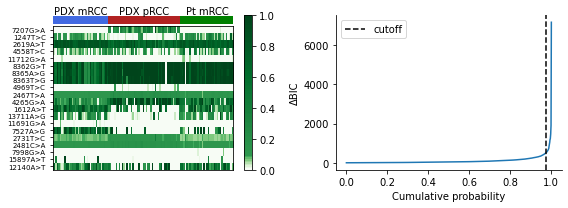

In [5]:
## Functions for plotting 2a and b
from matplotlib import cm as cmp
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cmp.get_cmap('Greens', 200)

newcolors = np.vstack((top(np.linspace(0, 0.7, 10)),
                    top(np.linspace(0.7, 1, 90))))
newcmp = ListedColormap(newcolors, name='segGreens')

def plot_figure_2a(a, d, ax):

    ## Convert sparse mtx to dense pd datafrane for more convient plotting
    AD_df = pd.DataFrame(a.todense(), index=var)
    DP_df = pd.DataFrame(d.todense(), index=var)

    ## flip the AF for 2619T>A, 8362T>G, 8365G>A, 8363G>T
    flip_var = ['2619A>T', '8362G>T', '8365A>G', '8363T>G']

    for v in flip_var:
        AD_df.loc[v] = DP_df.loc[v] - AD_df.loc[v]

    AF_df = AD_df/DP_df
    AF_df = AF_df.fillna(0)

    res = plt.imshow(AF_df[0:20], cmap = newcmp, aspect = 'auto', interpolation = 'none')
    plt.yticks(range(20), var[0:20], fontsize = 7)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    cb = plt.colorbar(res)

    divider = make_axes_locatable(ax)
    top_ax = divider.append_axes("top", size=0.13, pad=0.02, sharex=ax)
    label_num = [37,48,36]
    LEFT = 0
    iicolor = 0
    c_names = ['PDX mRCC', 'PDX pRCC', 'Pt mRCC']
    clone_pal = ['royalblue', 'firebrick', 'green']
    for num in label_num:
            top_ax.barh(0,num,left=LEFT,color=clone_pal[iicolor])
            top_ax.text(x=LEFT + num/2, y=0.8, s=c_names[iicolor], va='center', ha='center')
            top_ax.set_xlim(0,120)
            top_ax.axis('off')
            LEFT += num
            iicolor += 1

def plot_figure_2b(BIC, ax):
    
    x,y,knee,knee_y = findKnee(BIC.deltaBIC)
    plt.plot(x, y)
    plt.axvline(x=knee, color="black", linestyle='--',label="cutoff")
    plt.legend()
    plt.ylabel("\u0394BIC")
    plt.xlabel("Cumulative probability")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()


## Plot stuff

fig = plt.figure(figsize=(8,3))
ax = plt.subplot(1,2,1)
plot_figure_2a(mquad_AD, mquad_DP, ax)

ax = plt.subplot(1,2,2)
plot_figure_2b(BIC, ax)

In [6]:
## Convert sparse mtx to dense pd datafrane for more convient plotting
AD_df = pd.DataFrame(mquad_AD.todense(), index=var)
DP_df = pd.DataFrame(mquad_DP.todense(), index=var)

## flip the AF for 2619T>A, 8362T>G, 8365G>A, 8363G>T
flip_var = ['2619A>T', '8362G>T', '8365A>G', '8363T>G']

for v in flip_var:
    AD_df.loc[v] = DP_df.loc[v] - AD_df.loc[v]

AF_df = AD_df/DP_df
AF_df = AF_df.fillna(0)

p1 = AF_df.loc['7527A>G', 0:36]
p2 = AF_df.loc['7527A>G', 85:120]

from scipy.stats import ttest_ind

ttest_ind(p1, p2)

Ttest_indResult(statistic=4.6862615220301285, pvalue=1.3049263147933568e-05)

## Assign clones with vireo (Fig. 2c)
Here we fit the vireo model using the AD and DP matrices imported above. Then we visualize the clone assignment concordance with the source labels.

In [7]:
#fit on mquad output

## fix seed for more convenient reproducibility, realistically the seed does not have to be fixed, but the clone orders will shift
np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=3)
_model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

mquad_modelCA = _model

Precision = 0.9309523809523809
Recall = 0.9315565565565566


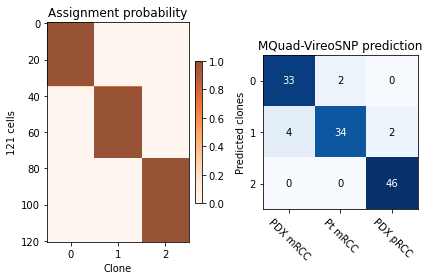

In [8]:
def plot_figure_2c_heatmap(ID_prob, model):
    im = heat_matrix(ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Assignment probability")
    plt.xlabel("Clone")
    plt.ylabel("%d cells" %(model.n_cell))
    plt.xticks(range(model.n_donor))
    plt.tight_layout()

def plot_figure_2c_confmatrix(ID_prob, ax, title="MQuad-VireoSNP prediction"):
    clone_id = np.argmax(ID_prob, axis=1)
    real_lab = ['PDX mRCC'] * 37 + ['PDX pRCC'] * 48 + ['Pt mRCC'] * 36
    #real_lab = ['PDX mRCC'] * 36 + ['PDX pRCC'] * 46 + ['Pt mRCC'] * 34

    confusion = confusionMatrix(clone_id, real_lab)
    confusion = confusion[["PDX mRCC", "Pt mRCC", "PDX pRCC"]]
    res = plot_confusionMatrix(confusion, ax)
    plt.title(title)
    plt.ylabel('Predicted clones')
    plt.xticks(range(3), confusion.columns,rotation=315)
    plt.yticks(range(len(confusion)), set(clone_id))
    plt.tight_layout()


#assignment prob heatmap
plt.subplot(1,2,1)
## reorder the clones to make the plots tidier
ID_prob_reordered = np.array([[i[2],i[0],i[1]] for i in mquad_modelCA.ID_prob])
plot_figure_2c_heatmap(ID_prob_reordered, mquad_modelCA)

#mquad confusion matrix
ax = plt.subplot(1,2,2)
plot_figure_2c_confmatrix(ID_prob_reordered, ax)

## Compare assignment with variants detected by mgatk (Fig. 2d)
Here we do the same thing, but with mgatk variants. 

In [9]:
np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mgatk_AD.getnnz(axis=1)), n_cell=len(mgatk_AD.getnnz(axis=0)), n_donor=3)
_model.fit(mgatk_AD, mgatk_DP, min_iter=30, n_init=300)

mgatk_modelCA = _model

Precision = 0.6321486928104575
Recall = 0.7115865865865866


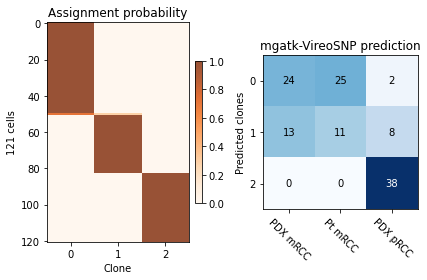

In [10]:
plt.subplot(1,2,1)
plot_figure_2c_heatmap(mgatk_modelCA.ID_prob, mgatk_modelCA)

#mquad confusion matrix
ax = plt.subplot(1,2,2)
plot_figure_2c_confmatrix(mgatk_modelCA.ID_prob, ax, title="mgatk-VireoSNP prediction")

Now we just need to put everything together with figure labels.

Precision = 0.9309523809523809
Recall = 0.9315565565565566
Precision = 0.6321486928104575
Recall = 0.7115865865865866


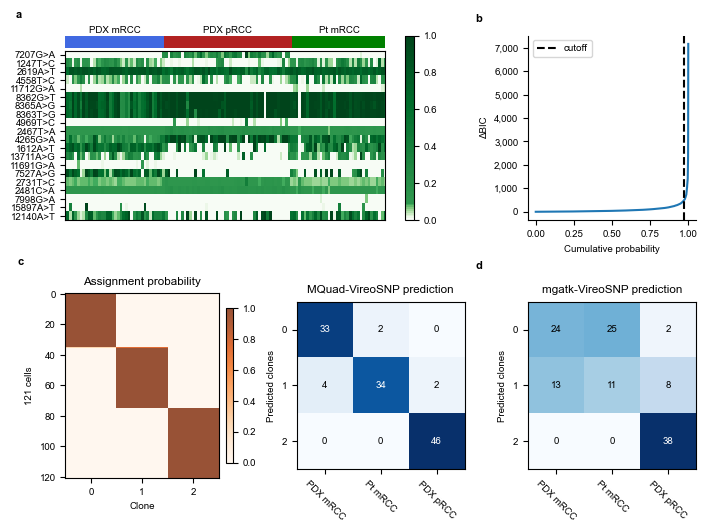

In [22]:
plt.style.use('default')
font = {'family' : 'Arial',
        'size'   : 7}
plt.rc('font', **font)
cm = 1/2.54
fig = plt.figure(figsize=(18*cm, 13.5*cm), dpi=100)

#AF heatmap
ax1 = plt.subplot2grid((2,3), (0,0), colspan=2)
ax1.text(-0.4*cm, 3*cm, 'a', transform = ax1.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_2a(mquad_AD, mquad_DP, ax1)

## BIC curve
ax2 = plt.subplot2grid((2,3), (0,2), colspan=1)
ax2.text(-0.8*cm, 2.7*cm, 'b', transform = ax2.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
ax2.get_yaxis().set_major_formatter(
   mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plot_figure_2b(BIC, ax2)


#assignment prob heatmap
ax3 = plt.subplot2grid((2,3), (1,0), colspan=1)
ax3.text(-0.8*cm, 2.9*cm, 'c', transform = ax3.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_2c_heatmap(ID_prob_reordered, mquad_modelCA)

#mquad confusion matrix
ax4 = plt.subplot2grid((2,3), (1,1), colspan=1)
plot_figure_2c_confmatrix(ID_prob_reordered, ax4)


#mgatk confusion matrix
ax5 = plt.subplot2grid((2,3), (1,2), colspan=1)
ax5.text(-0.8*cm, 3*cm, 'd', transform = ax5.transAxes, fontsize = 8, fontweight = 'bold', va='bottom', ha='left')
plot_figure_2c_confmatrix(mgatk_modelCA.ID_prob, ax5, title="mgatk-VireoSNP prediction")


plt.savefig('figures/Figure_2.pdf')

## RANDOM STUFF BELOW PLS REMOVE

In [12]:
bnpc_assignment = pd.read_table('/home/aaronkwc/data/20211108_16:06:14/assignment.txt')
bnpc_assignment.head()

,chain,estimator,Assignment
0,mean,posterior,8 6 13 10 3 2 6 2 13 10 10 2 8 8 8 10 12 3 8 8...


In [13]:
bnpc_assignment_list = [int(x) for x in bnpc_assignment.Assignment[0].split()]

In [14]:
cluster_post = pd.read_table('data/SCITE/nodoublet/cluster_posteriors.tsv', index_col=0)
clusters = np.argmax(cluster_post.values, axis=1)

Precision = 0.2971721721721722
Recall = 0.834815705128205
Precision = 0.31532091097308484
Recall = 0.8353365384615384
Precision = 0.8217960858585859
Recall = 0.5103853853853854
Precision = 0.7756281912531913
Recall = 0.5109730848861284


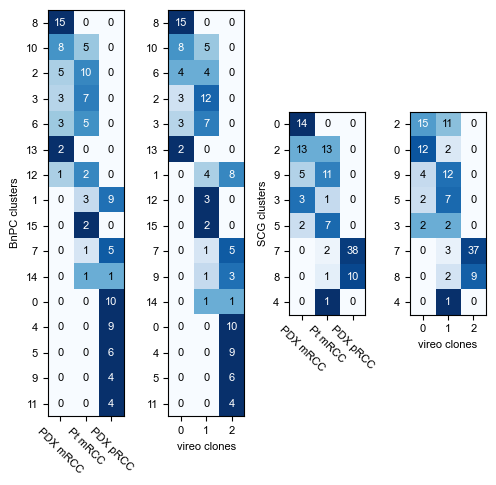

In [15]:
real_lab = ['PDX mRCC'] * 37 + ['PDX pRCC'] * 48 + ['Pt mRCC'] * 36
confMat = confusionMatrix(real_lab, bnpc_assignment_list)

fig = plt.figure(figsize=(5,8))
ax = plt.subplot(1,4,1)
confMat = confMat.T[["PDX mRCC", "Pt mRCC", "PDX pRCC"]]
confMat = confMat.sort_values(by=["PDX mRCC", "Pt mRCC", "PDX pRCC"], ascending=False)

plot_confusionMatrix(confMat, ax)
plt.yticks(range(16), confMat.index)
plt.xticks([0,1,2],["PDX mRCC", "Pt mRCC", "PDX pRCC"], rotation=315)
plt.ylabel('BnPC clusters')

ax=plt.subplot(1,4,2)
confMat = confusionMatrix(np.argmax(ID_prob_reordered, axis=1), bnpc_assignment_list).T.sort_values(by=[0, 1, 2], ascending=False)
plot_confusionMatrix(confMat, ax=ax)
plt.yticks(range(16), confMat.index)
plt.xticks([0,1,2])
plt.xlabel('vireo clones')
plt.tight_layout()

ax = plt.subplot(1,4,3)
confMat = confusionMatrix(clusters, real_lab)
confMat = confMat[['PDX mRCC', 'Pt mRCC', 'PDX pRCC']]
confMat = confMat.sort_values(by=["PDX mRCC", "Pt mRCC", "PDX pRCC"], ascending=False)
plot_confusionMatrix(confMat, ax=ax)
plt.yticks(range(8), confMat.index)
plt.xticks([0,1,2],["PDX mRCC", "Pt mRCC", "PDX pRCC"], rotation=315)
plt.ylabel('SCG clusters')

ax = plt.subplot(1,4,4)
confMat = confusionMatrix(clusters, np.argmax(ID_prob_reordered, axis=1))
confMat = confMat.sort_values(by=[0,1,2], ascending=False)
plot_confusionMatrix(confMat, ax=ax)
plt.yticks(range(8), confMat.index)
plt.xticks([0,1,2])
plt.xlabel('vireo clones')

plt.tight_layout()
plt.savefig('figures/bnpc_scg.pdf')

In [16]:
## visualize mgatk output

mgatk = pd.read_csv('data/mgatk/final/misc_df.csv')
mgatk[['ref', 'alt']] = mgatk.nucleotide.str.split('>', expand=True)
mgatk['mquad_variant_name'] = 'chrM_' + mgatk.position.astype(str) + '_' + mgatk.ref + '_' + mgatk.alt
mgatk['is_detected_by_mquad'] = mgatk.variant.isin(var)

In [17]:
mgatk.head()

,Unnamed: 0,position,nucleotide,variant,vmr,mean,variance,n_cells_conf_detected,n_cells_over_5,n_cells_over_10,n_cells_over_20,strand_correlation,mean_coverage,ref,alt,mquad_variant_name,is_detected_by_mquad
0,1G>A,1,G>A,1G>A,0.000000,0.000000,0.000000,0,0,0,0,NaN,14.198347,G,A,chrM_1_G_A,False
1,3T>A,3,T>A,3T>A,0.009434,0.001110,0.000010,0,1,1,1,NaN,14.884298,T,A,chrM_3_T_A,False
2,4C>A,4,C>A,4C>A,0.000000,0.000000,0.000000,0,0,0,0,NaN,15.041322,C,A,chrM_4_C_A,False
3,6C>A,6,C>A,6C>A,0.000000,0.000000,0.000000,0,0,0,0,NaN,15.520661,C,A,chrM_6_C_A,False
4,8G>A,8,G>A,8G>A,0.004732,0.000501,0.000002,0,0,0,0,NaN,16.504132,G,A,chrM_8_G_A,False


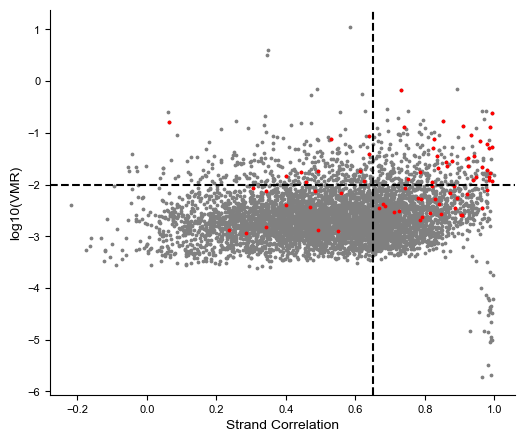

In [18]:
## only show n_cells_conf_detected > 5
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
mgatk_plot = mgatk[(mgatk.n_cells_conf_detected > 5) & (mgatk.mean_coverage > 50)]
plt.scatter(mgatk_plot.strand_correlation, np.log10(mgatk_plot.vmr), color='grey', s=3)
plt.scatter(mgatk_plot[mgatk_plot.is_detected_by_mquad == True].strand_correlation, np.log10(mgatk_plot[mgatk_plot.is_detected_by_mquad == True].vmr), color='red', s=3)
plt.axhline(y=-2, linestyle='--', color='black')
plt.axvline(x=0.65, linestyle='--', color='black')
plt.ylabel('log10(VMR)', fontsize=10)
plt.xlabel('Strand Correlation', fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('figures/mgatk_plot.png')


In [19]:
## function to convert hg19 chrM to hg19 chrMT (rCRS) nomenclature

mquad_BIC = pd.read_csv('data/cellsnp_rerun_rCRS/mquad/BIC_params.csv')


def convert_rCRS(variant_names, convert=True):

    converted=[]

    if convert:

        for name in variant_names:
            pos = int(name.split('_')[1])
            #print(pos)
            ref = name.split('_')[2]
            alt = name.split('_')[3]

            if pos < 315:
                converted.append(str(pos))
            elif 3107 > pos >=315:
                converted.append(str(pos - 2))
            elif 16193 > pos >= 3107:
                converted.append(str(pos - 1))
            elif pos >= 16193:
                converted.append(str(pos - 2))
    else:
        converted = [i.split('_')[1] for i in variant_names]

    return(converted)



## convert informative variants' names into rCRS format
fixed_names = convert_rCRS(mquad_BIC[(mquad_BIC.PASS_KP == True) & (mquad_BIC.PASS_MINCELLS == True)].variant_name, convert=False)

len(fixed_names)


171